In [16]:
from sshtunnel import SSHTunnelForwarder
import mysql.connector
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import getpass

In [30]:
public_ip = input('Введите IPv4 Public IP: ')
password_mysql = getpass.getpass(prompt="Введите пароль от MySQL-сервера: ")

server = SSHTunnelForwarder(
    (public_ip, 22),
    ssh_host_key=None,
    ssh_username="ubuntu",
    ssh_password=None,
    ssh_private_key='../key1_GB.pem',
    ssh_private_key_password=None,
    remote_bind_address=("127.0.0.1", 3306))

server.start()

mydb=mysql.connector.connect(
    user='root',
    password=password_mysql,
    host="127.0.0.1", 
    port=server.local_bind_port, 
    database='db_for_analyt')

print(mydb)

Введите IPv4 Public IP:  54.93.100.104
Введите пароль от MySQL-сервера:  ········


In [18]:
mycursor = mydb.cursor()
current_db = "orders_20190822"

In [26]:
def execute_(sql, columns):
    mycursor.execute(sql)
    myresult = mycursor.fetchall()
    return pd.DataFrame(myresult, columns=columns)

## Выполнение запросов

### 2.Проанализировать, какой период данных выгружен

In [29]:
%%time
execute_(
    sql=f"SELECT MIN(o_date), max(o_date) FROM {current_db}", 
    columns=['c', 'по'])

Wall time: 1.02 s


,c,по
0,2016-01-01,2017-12-31


### 3. Посчитать кол-во строк, кол-во заказов и кол-во уникальных пользователей, которые совершали заказы.

In [164]:
execute_(
    f"SELECT COUNT(id_o) FROM {current_db}",
    columns=['количество заказов всего'])

,количество заказов всего
0,2002804


In [165]:
execute_(
    sql=f"SELECT COUNT(DISTINCT user_id) FROM {current_db}",
    columns=['user_id уникальнае'])

,user_id уникальнае
0,1015119


### 4. По годам посчитать средний чек, среднее кол-во заказов на пользователя, сделать вывод , как изменялись это показатели Год от года.

In [167]:
df = execute_(
    sql='SELECT YEAR(o_date), AVG(price), AVG(id_o) FROM orders_20190822 GROUP BY YEAR(o_date)',
    columns=['год', 'средний чек', 'кол-во заказов на пользователя'])
df

,год,средний чек,кол-во заказов на пользователя
0,2016,2095.583717,2297178.8816
1,2017,2398.392923,5229664.9826


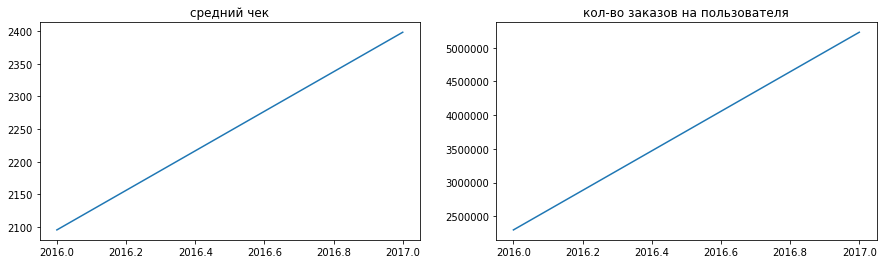

In [170]:
x = df['год']
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x, df['средний чек'])
plt.title('средний чек')
plt.subplot(1, 2, 2)
plt.plot(x, df['кол-во заказов на пользователя'])
plt.title('кол-во заказов на пользователя');

### 5. Найти кол-во пользователей, которые покупали в одном году и перестали покупать в следующем.

In [20]:
execute_(
    sql='SELECT COUNT(DISTINCT user_id) FROM (SELECT user_id FROM orders_20190822 WHERE YEAR (o_date) = 2016 '
    'UNION SELECT user_id FROM orders_20190822 WHERE YEAR (o_date) != 2017) as departed',
    columns=['число покинувших пользователей'])

,число покинувших пользователей
0,445092


### 6. Найти ID самого активного по кол-ву покупок пользователя.

In [22]:
%%time
execute_(
    sql='SELECT user_id FROM orders_20190822 GROUP BY user_id ORDER BY COUNT(id_o) DESC LIMIT 1',
    columns=['user_id'])

Wall time: 2.4 s


,user_id
0,765861


## Закрытие сессии

In [194]:
mydb.close()

In [195]:
server.stop()